In [ ]:
!pip install -q yfinance

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# For time stamps
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional
from google.colab import files

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
yf.pdr_override()

# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
def custom_train_test_split(dataset, ratio=0.9):
  # Get the number of rows to train the model on
  training_data_len = int(np.ceil(len(dataset)*ratio))
  # Create the training data set
  # Create the scaled training data set
  train_data = scaled_data[0:int(training_data_len), :]
  # Split the data into x_train and y_train data sets
  x_train = []
  y_train = []
  for i in range(60, len(train_data)):
      x_train.append(train_data[i-60:i, 0])
      y_train.append(train_data[i, 0])

  # Convert the x_train and y_train to numpy arrays
  x_train, y_train = np.array(x_train), np.array(y_train)

  # Reshape the data
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  # Create the testing data set
  test_data = scaled_data[training_data_len-60:, :]
  # Create the data sets x_test and y_test
  x_test = []
  y_test = dataset[training_data_len:, :]
  for i in range(60, len(test_data)):
      x_test.append(test_data[i-60:i, 0])

  # Convert the data to a numpy array
  x_test = np.array(x_test)

  # Reshape the data
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  return x_train, y_train, x_test, y_test, training_data_len

Apple

In [ ]:
# Get the stock quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())

# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Custom train-test split
x_train, y_train, x_test, y_test, training_data_len = custom_train_test_split(dataset)

print('\nMean price of Closing Price USD ($) of testing set: ', np.mean(y_test))
print('\n', len(x_train))
print('\n', len(x_test))

[*********************100%%**********************]  1 of 1 completed


Mean price of Closing Price USD ($) of testing set:  170.74500006123594

 2679

 304


10/10 [==============================] - 1s 23ms/step
RMSE for LSTM model:  5.417671262925721


<ipython-input-7-95a4d1cde9ee>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

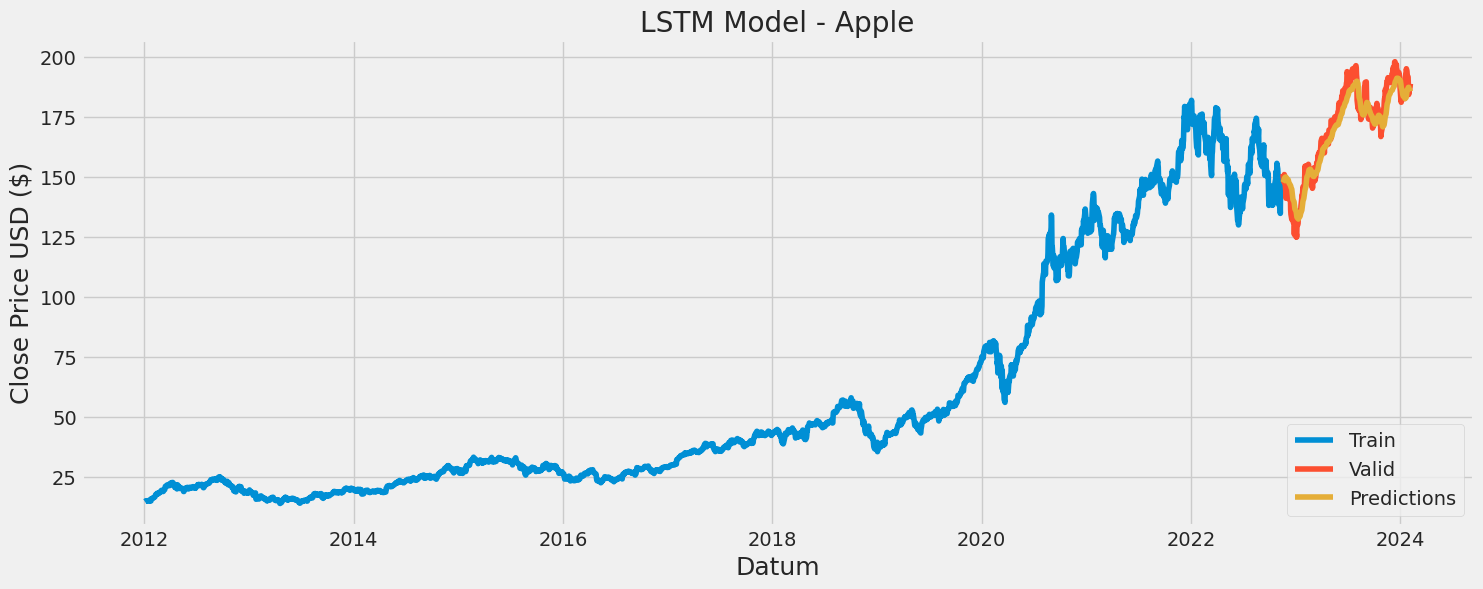

In [ ]:
# Build the LSTM model

model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for LSTM model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model - Apple')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("LSTM-Apple.png")
files.download("LSTM-Apple.png")
plt.show()

10/10 [==============================] - 0s 16ms/step
RMSE for GRU model:  3.1450294320396783


<ipython-input-8-37f78d610a72>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

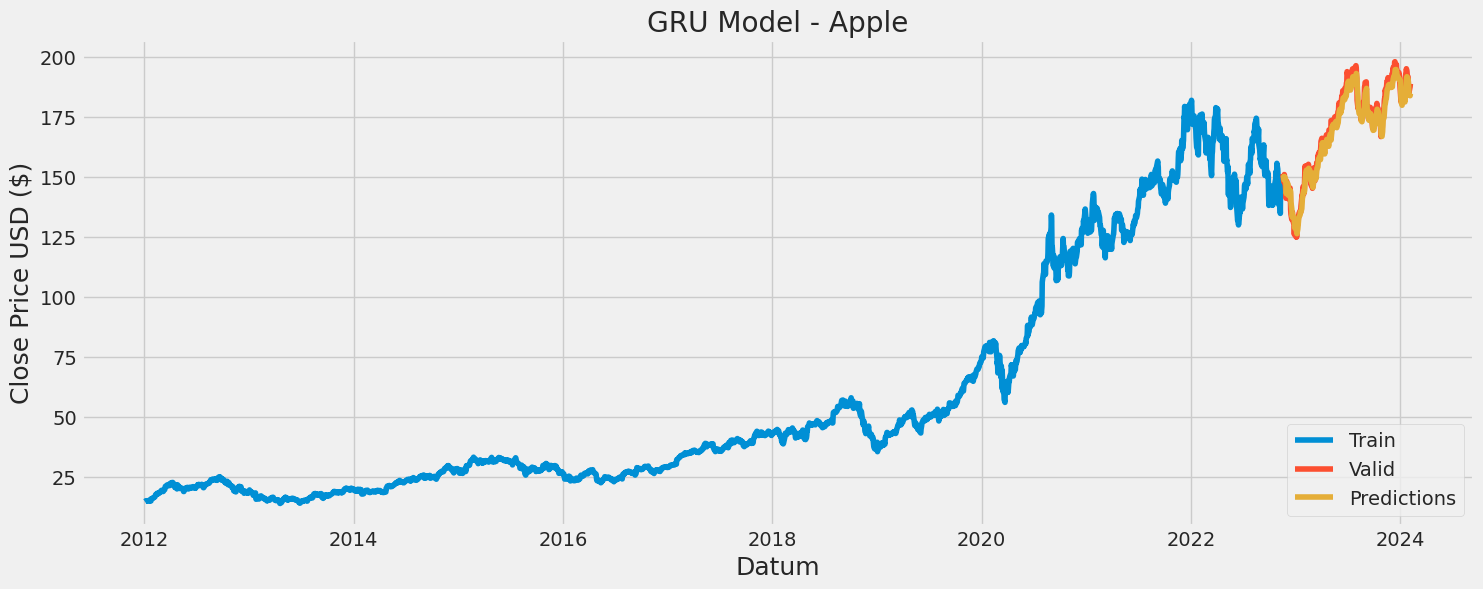

In [ ]:
# Build the GRU model

model = Sequential()
model.add(GRU(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(GRU(64, activation='relu', return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for GRU model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('GRU Model - Apple')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("GRU-Apple.png")
files.download("GRU-Apple.png")
plt.show()

10/10 [==============================] - 2s 92ms/step
RMSE for BiLSTM model:  7.286731655558439


<ipython-input-9-672eeafedf56>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

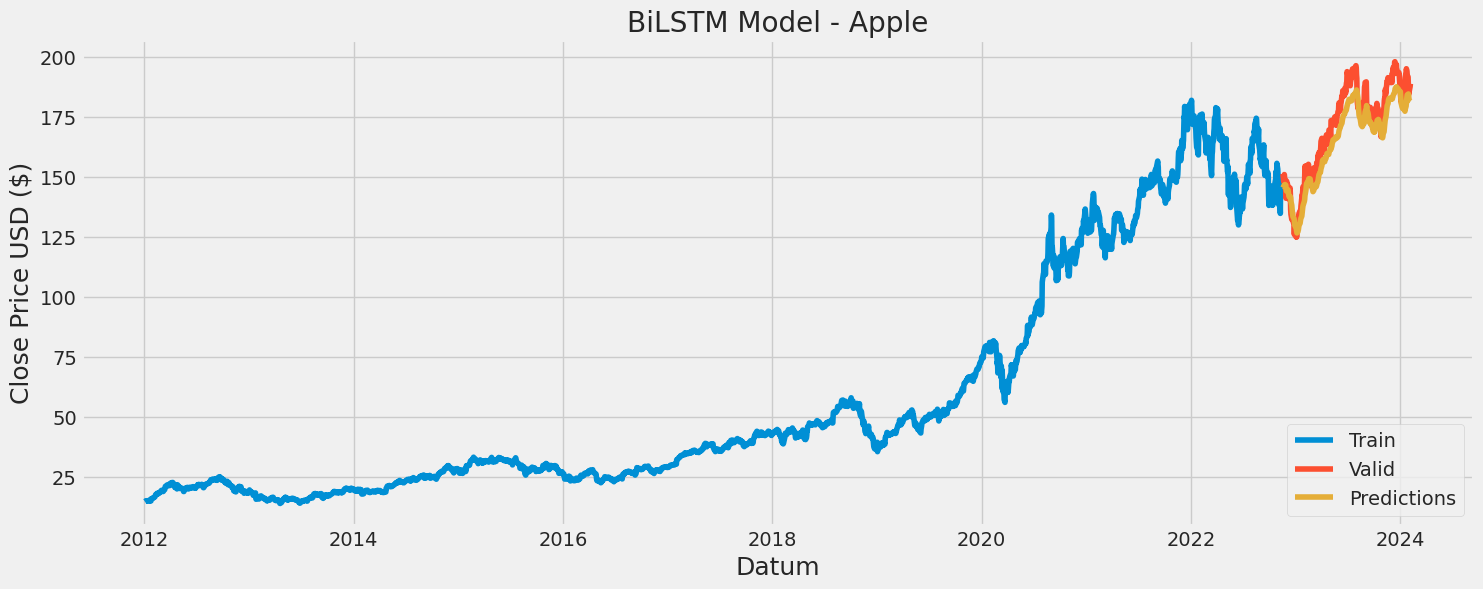

In [ ]:
# Build the BiLSTM model

model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1))))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=False)))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for BiLSTM model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('BiLSTM Model - Apple')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("BiLSTM-Apple.png")
files.download("BiLSTM-Apple.png")
plt.show()

Google

In [ ]:
# Get the stock quote
df = pdr.get_data_yahoo('GOOG', start='2012-01-01', end=datetime.now())

# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Custom train-test split
x_train, y_train, x_test, y_test, training_data_len = custom_train_test_split(dataset)

print('\nMean price of Closing Price USD ($) of testing set: ', np.mean(y_test))

[*********************100%%**********************]  1 of 1 completed


Mean price of Closing Price USD ($) of testing set:  119.27922708109806


10/10 [==============================] - 1s 24ms/step
RMSE for LSTM model:  3.9573150014632597


<ipython-input-11-64efa2768774>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

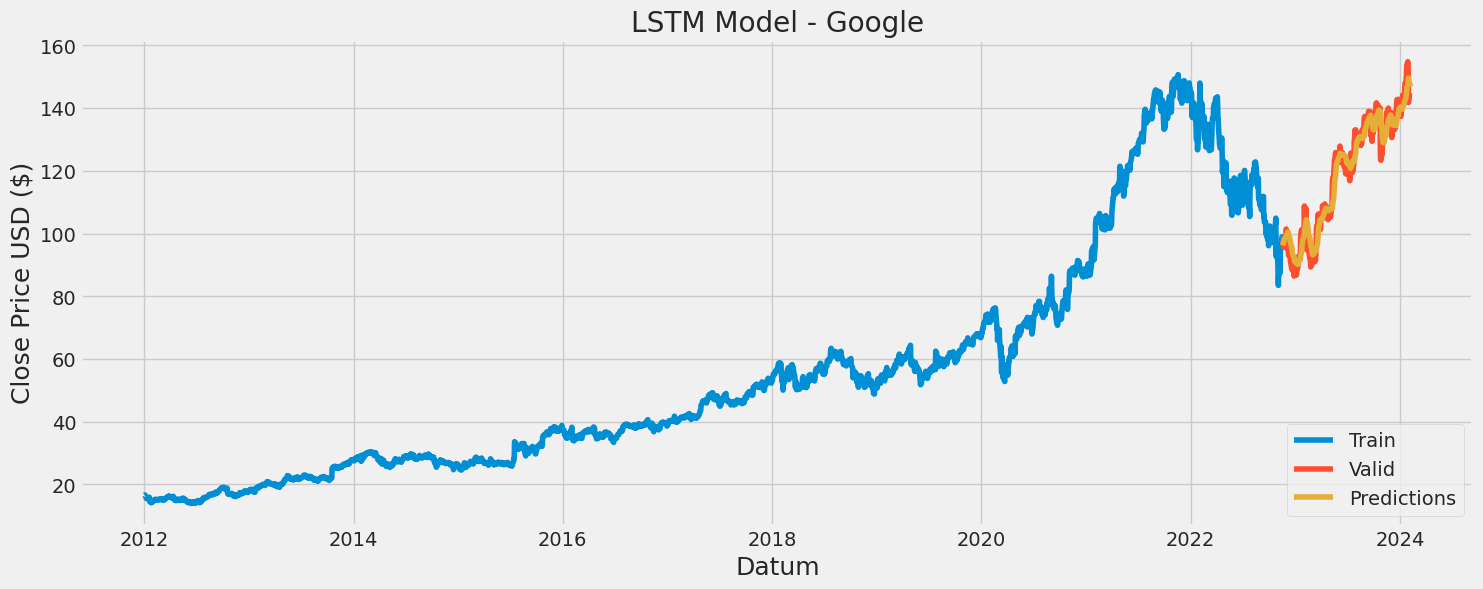

In [ ]:
# Build the LSTM model

model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for LSTM model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model - Google')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("LSTM-Google.png")
files.download("LSTM-Google.png")
plt.show()

10/10 [==============================] - 0s 17ms/step
RMSE for GRU model:  3.511671573416263


<ipython-input-12-4e411ef546a3>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

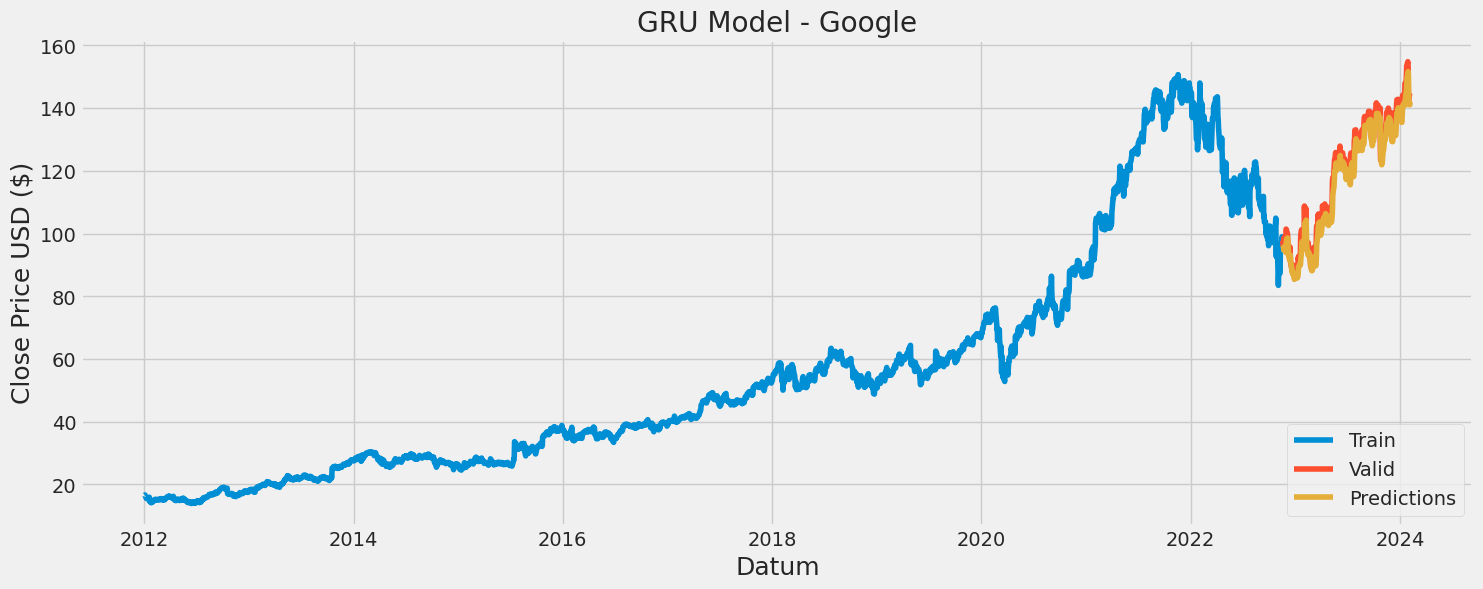

In [ ]:
# Build the GRU model

model = Sequential()
model.add(GRU(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(GRU(64, activation='relu', return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for GRU model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('GRU Model - Google')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("GRU-Google.png")
files.download("GRU-Google.png")
plt.show()

10/10 [==============================] - 1s 46ms/step
RMSE for BiLSTM model:  8.122957806433597


<ipython-input-26-2594c7d1d0e9>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

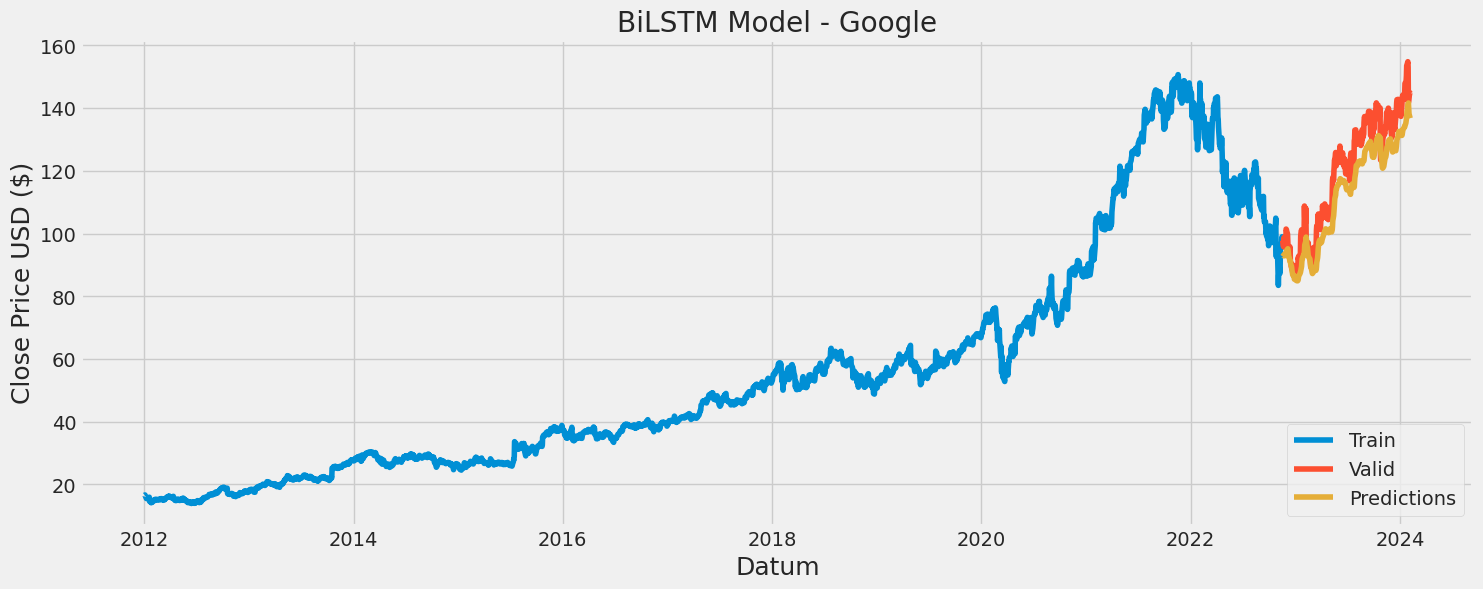

In [ ]:
# Build the BiLSTM model

model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1))))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=False)))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for BiLSTM model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('BiLSTM Model - Google')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("BiLSTM-Google.png")
files.download("BiLSTM-Google.png")
plt.show()

Microsoft

In [ ]:
# Get the stock quote
df = pdr.get_data_yahoo('MSFT', start='2012-01-01', end=datetime.now())

# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Custom train-test split
x_train, y_train, x_test, y_test, training_data_len = custom_train_test_split(dataset)

print('\nMean price of Closing Price USD ($) of testing set: ', np.mean(y_test))

[*********************100%%**********************]  1 of 1 completed


Mean price of Closing Price USD ($) of testing set:  315.56526344700865


10/10 [==============================] - 0s 22ms/step
RMSE for LSTM model:  7.858278058346219


<ipython-input-15-e3a2dc4444a3>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

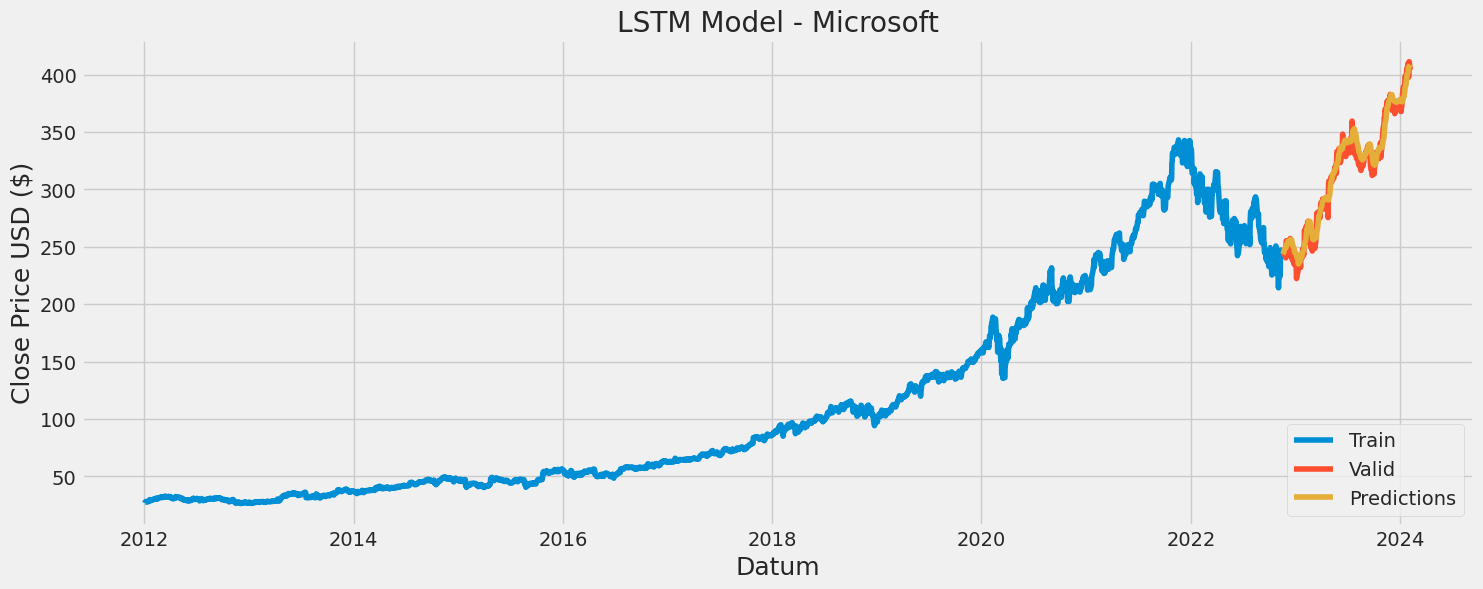

In [ ]:
# Build the LSTM model

model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for LSTM model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model - Microsoft')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("LSTM-Microsoft.png")
files.download("LSTM-Microsoft.png")
plt.show()

10/10 [==============================] - 1s 21ms/step
RMSE for GRU model:  5.589374110532044


<ipython-input-7-03f0ff4f013c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

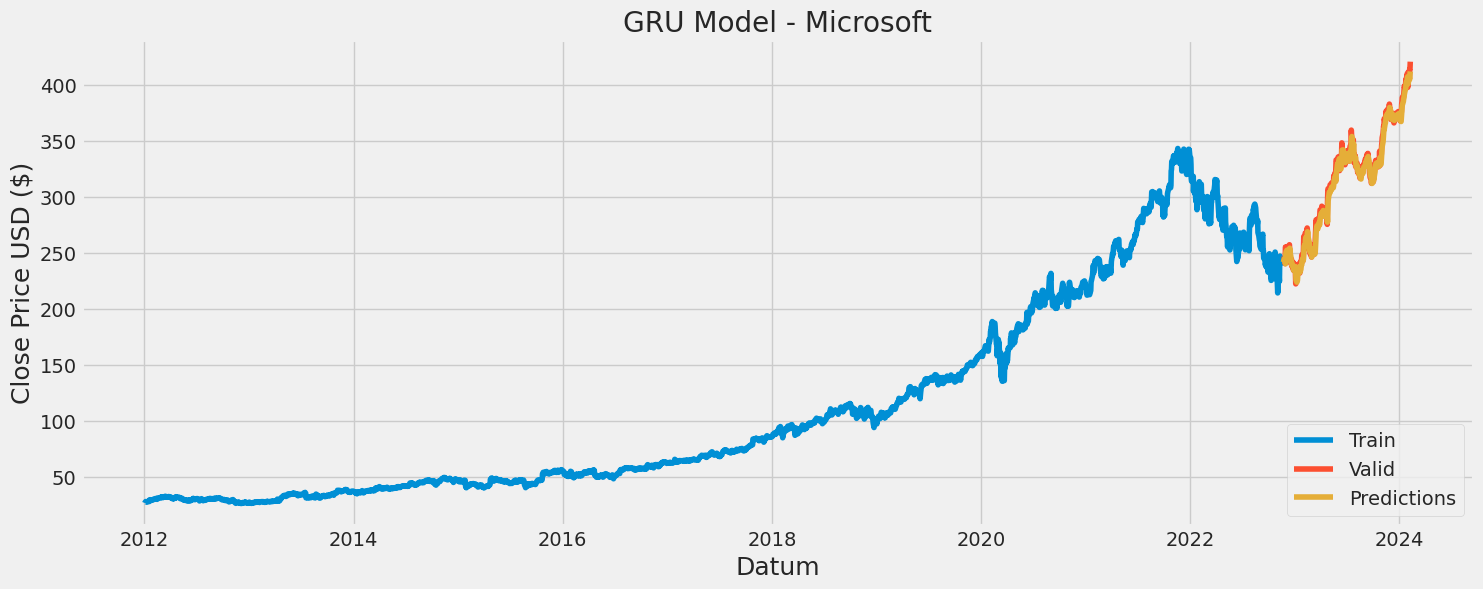

In [ ]:
# Build the GRU model

model = Sequential()
model.add(GRU(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(GRU(64, activation='relu', return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for GRU model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('GRU Model - Microsoft')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("GRU-Microsoft.png")
files.download("GRU-Microsoft.png")
plt.show()

10/10 [==============================] - 1s 46ms/step
RMSE for BiLSTM model:  9.595180058039768


<ipython-input-17-03c63d878656>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

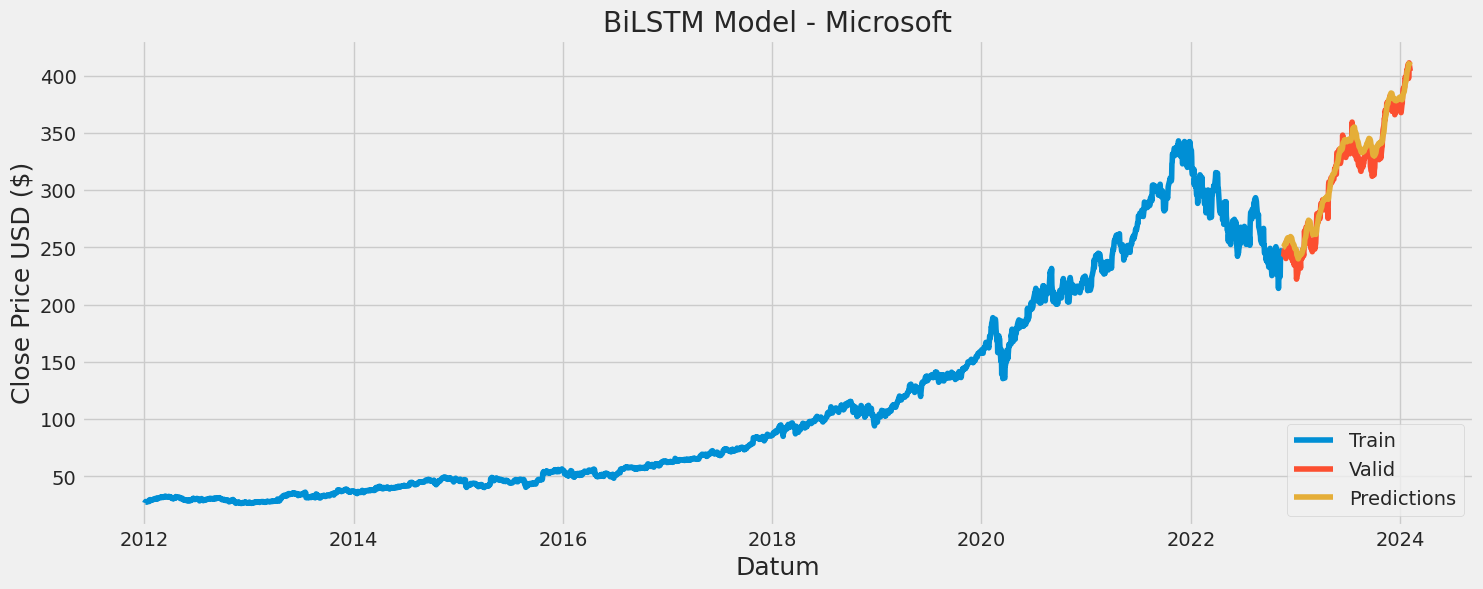

In [ ]:
# Build the BiLSTM model

model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1))))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=False)))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for BiLSTM model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('BiLSTM Model - Microsoft')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("BiLSTM-Microsoft.png")
files.download("BiLSTM-Microsoft.png")
plt.show()

Amazon

In [ ]:
# Get the stock quote
df = pdr.get_data_yahoo('AMZN', start='2012-01-01', end=datetime.now())

# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Custom train-test split
x_train, y_train, x_test, y_test, training_data_len = custom_train_test_split(dataset)

print('\nMean price of Closing Price USD ($) of testing set: ', np.mean(y_test))

[*********************100%%**********************]  1 of 1 completed


Mean price of Closing Price USD ($) of testing set:  121.17248372027748


10/10 [==============================] - 1s 35ms/step
RMSE for LSTM model:  4.014339885284976


<ipython-input-23-3409fddf7b11>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

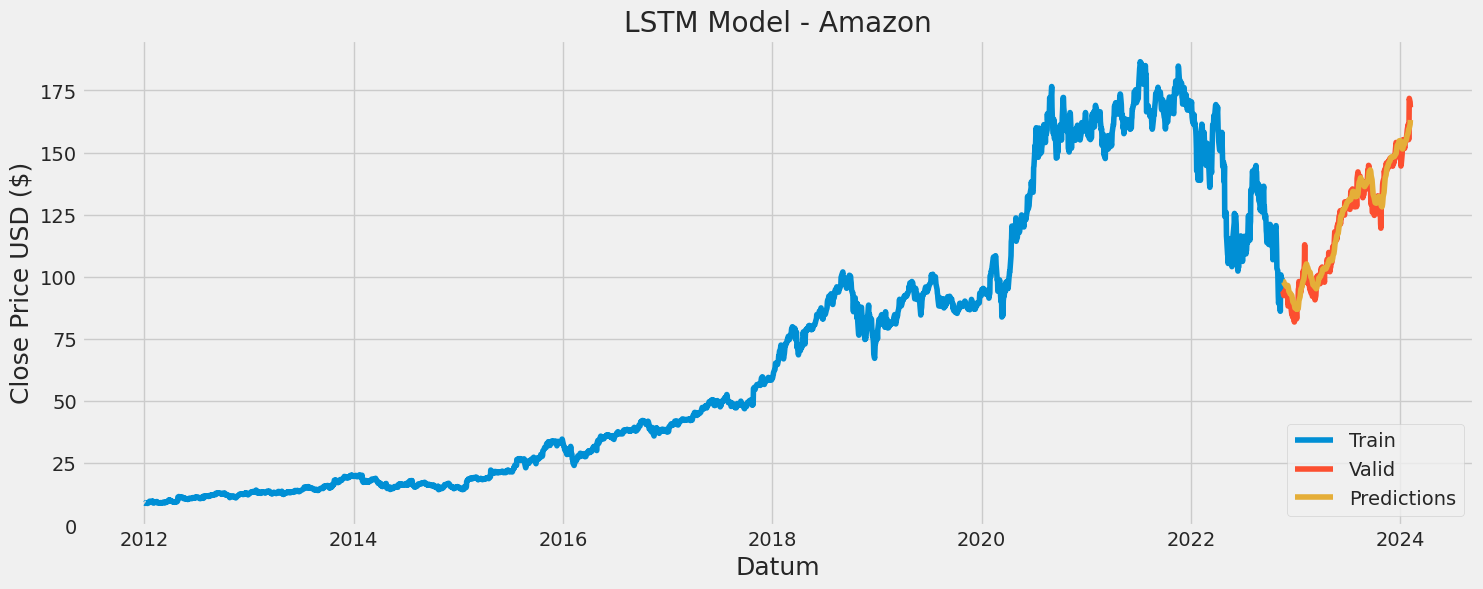

In [ ]:
# Build the LSTM model

model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for LSTM model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model - Amazon')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("LSTM-Amazon.png")
files.download("LSTM-Amazon.png")
plt.show()

10/10 [==============================] - 0s 16ms/step
RMSE for GRU model:  3.362529015320687


<ipython-input-20-9d86377877c2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

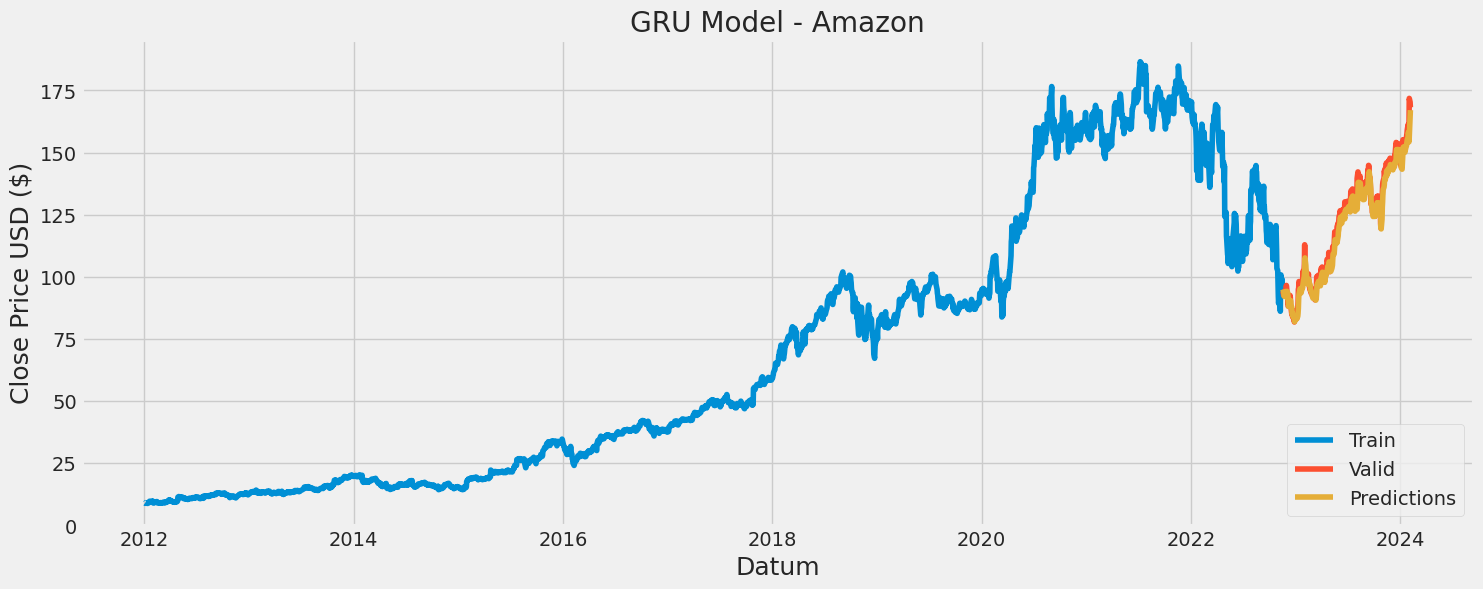

In [ ]:
# Build the GRU model

model = Sequential()
model.add(GRU(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(GRU(64, activation='relu', return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for GRU model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('GRU Model - Amazon')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("GRU-Amazon.png")
files.download("GRU-Amazon.png")
plt.show()

10/10 [==============================] - 1s 49ms/step
RMSE for BiLSTM model:  5.1875140625798695


<ipython-input-21-087a4835d7fb>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

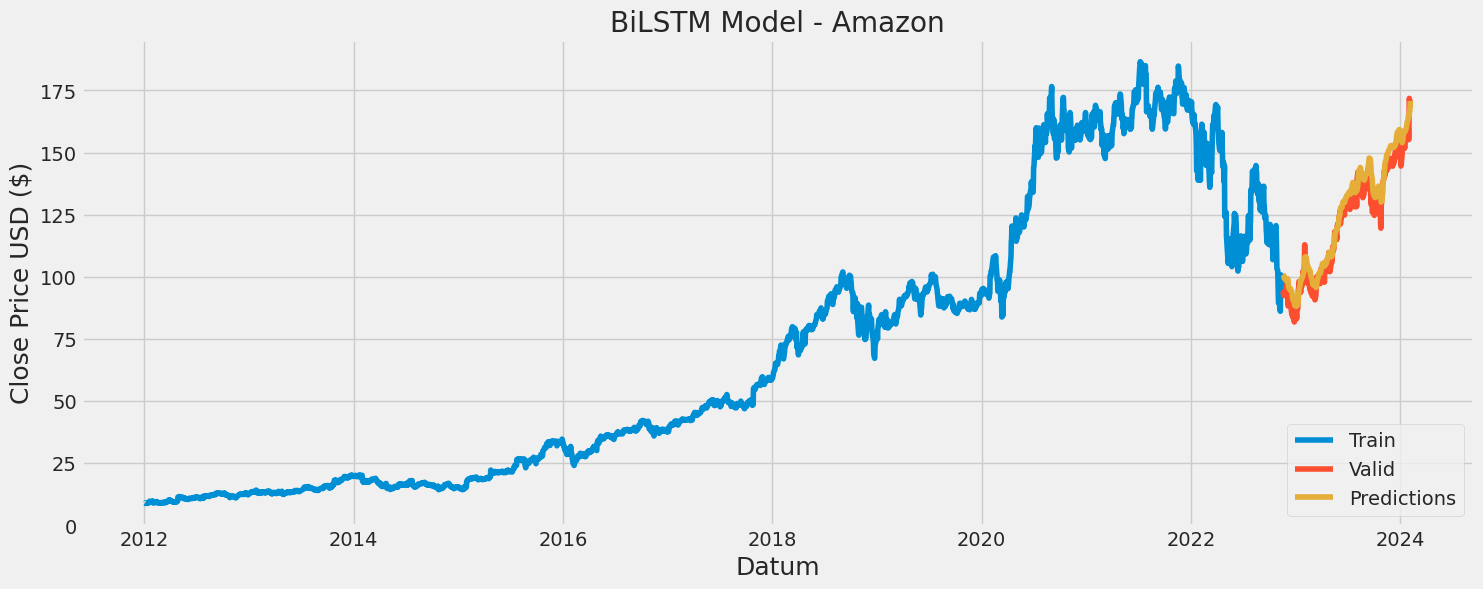

In [ ]:
# Build the BiLSTM model

model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1))))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=False)))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE for BiLSTM model: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('BiLSTM Model - Amazon')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.savefig("BiLSTM-Amazon.png")
files.download("BiLSTM-Amazon.png")
plt.show()